<a href="https://colab.research.google.com/github/kmouts/examples/blob/main/example_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Upsampling in a Single Forward Pass with FeatUp (JBU)

> ⚠️ Change your collab runtime to T4 GPU before running this notebook

In this notebook we will walk through how to load and work with our catalog of pre-trained upsamplers that work with common vision backbones such as CLIP, DINO, DINO v2, and ResNet50. We note that we add a Layer Norm operation to each of these backbones prior to upsampling so keep this in mind if you are trying to replace an existing component with one of our upsampled variants.

In [4]:
!git clone https://github.com/mhamilton723/FeatUp

fatal: destination path 'FeatUp' already exists and is not an empty directory.


## Install FeatUp and our fast Joint Bilateral Upsampling (JBU) Kernel

> ⚠️ This cell will take 3-5 minutes to run because of cuda kernel compilation


In [5]:
import os
os.chdir("FeatUp/")

In [6]:
!pip install -e .
!pip install git+https://github.com/mhamilton723/CLIP.git

Obtaining file:///content/FeatUp
  Preparing metadata (setup.py) ... done
  Attempting uninstall: featup
    Found existing installation: featup 0.1.2
    Uninstalling featup-0.1.2:
      Successfully uninstalled featup-0.1.2
  Running setup.py develop for featup
  Cloning https://github.com/mhamilton723/CLIP.git to /tmp/pip-req-build-_n2hau2p
  Running command git clone --filter=blob:none --quiet https://github.com/mhamilton723/CLIP.git /tmp/pip-req-build-_n2hau2p
  Resolved https://github.com/mhamilton723/CLIP.git to commit dce9d43cc659cb9a013745b378c78077fde6aac0
  Preparing metadata (setup.py) ... done


In [7]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats

In [8]:
input_size = 224
image_path = "sample-images/hand1.jpg"

transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).cuda()

In [12]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00


## DINO

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 216MB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/dino16_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/dino16_jbu_stack_cocostuff.ckpt
100%|██████████| 2.04M/2.04M [00:02<00:00, 916kB/s] 
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:lightning_fabric.utilities.s

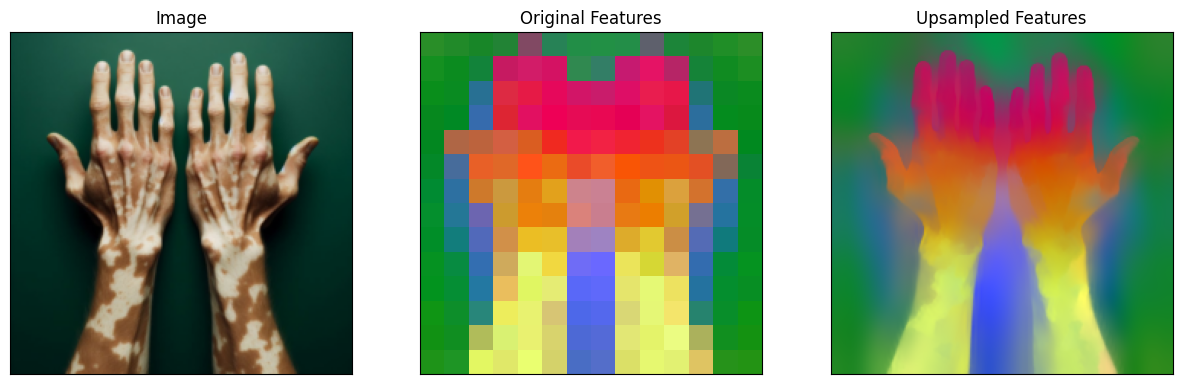

In [13]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', trust_repo=True).cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])


## DINO v2

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/content/FeatUp/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/content/FeatUp/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/content/FeatUp/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)


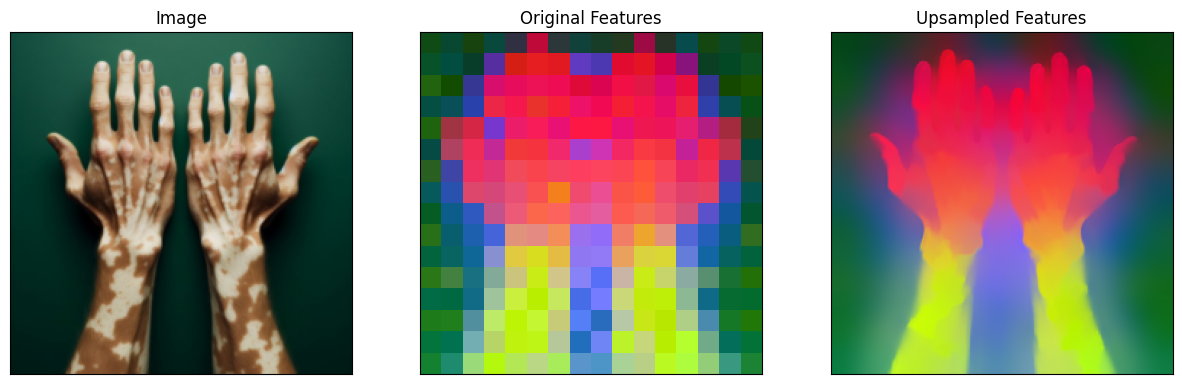

In [14]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', trust_repo=True).cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

## CLIP

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
100%|███████████████████████████████████████| 335M/335M [00:16<00:00, 20.8MiB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/clip_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/clip_jbu_stack_cocostuff.ckpt
100%|██████████| 3.35M/3.35M [00:02<00:00, 1.37MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


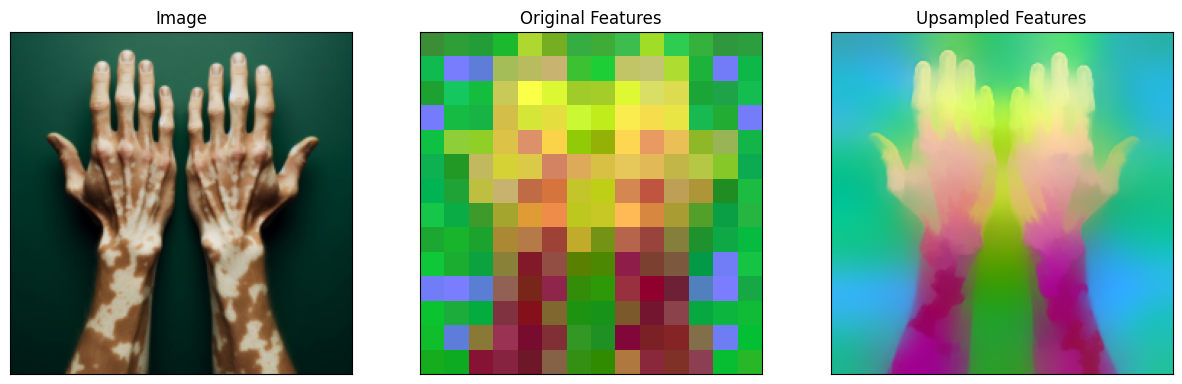

In [15]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'clip', trust_repo=True).cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ViT

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/vit_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/vit_jbu_stack_cocostuff.ckpt
100%|██████████| 2.04M/2.04M [00:01<00:00, 1.07MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


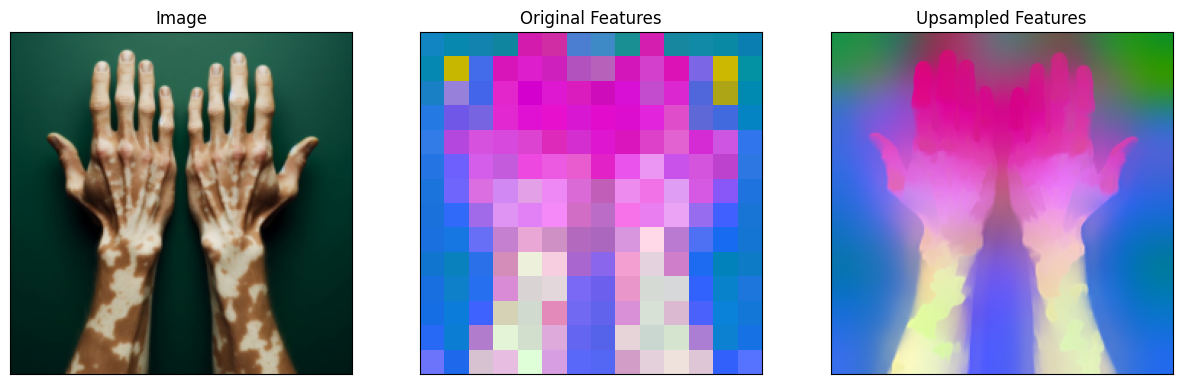

In [16]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'vit').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ResNet 50

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/resnet50_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/resnet50_jbu_stack_cocostuff.ckpt
100%|██████████| 48.4M/48.4M [00:09<00:00, 5.61MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


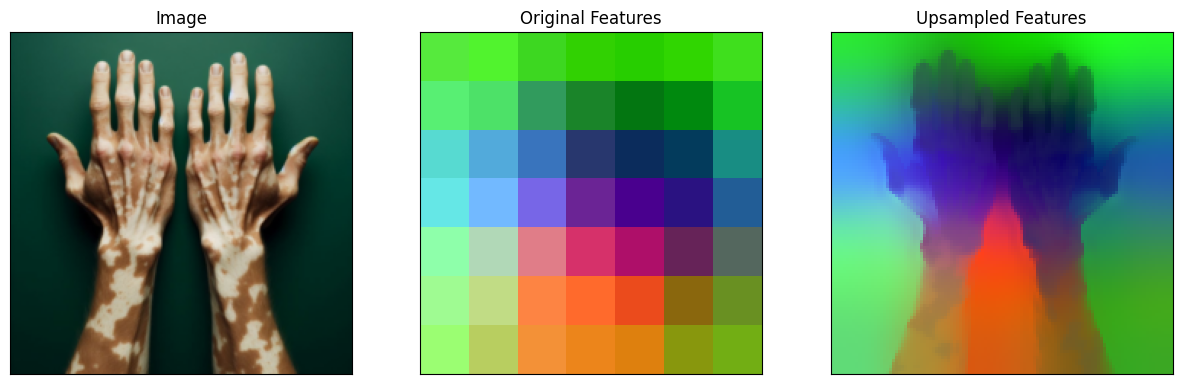

In [17]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'resnet50', trust_repo=True).cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

INFO:lightning_fabric.utilities.seed:Seed set to 0


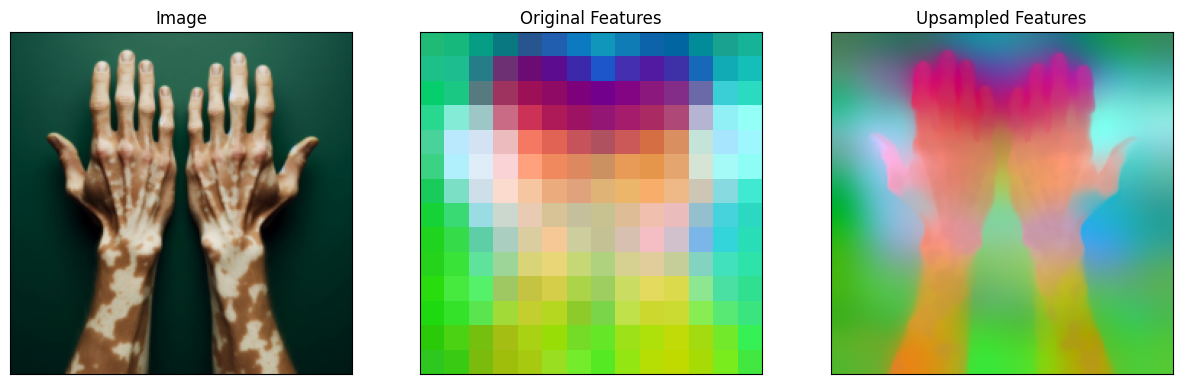

In [18]:
import torch.nn.functional as F

big_img = F.interpolate(image_tensor, scale_factor=2, mode='bilinear')
hr_feats = upsampler(big_img)
lr_feats = upsampler.model(big_img)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])